## Preparing Environement

In [19]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys
# add the 'src' directory as one where we can import modules
root_dir = os.path.join(os.getcwd(),os.pardir,os.pardir)
src_dir = os.path.join(root_dir, 'src')
if src_dir not in sys.path: sys.path.append(src_dir)
    
import math
import copy as cp
from datetime import datetime

import numpy as np
import pandas as pd

import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans,Birch,AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn import preprocessing

from scipy.cluster import hierarchy
from scipy import stats
from scipy.stats import mstats

import helpers as hlp
%aimport helpers
from external import kMedoids
from IPython.display import display

from dotenv import find_dotenv, load_dotenv
#Load env vars
load_dotenv(find_dotenv())


#printing
pd.options.display.float_format = '{:,.2f}'.format


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load preprocessed data

In [227]:
subfolder = os.getenv("SUBFOLDER")
PREFIX = os.getenv("PREFIX")
raw_path = os.path.join(root_dir,"data\\raw\\",subfolder)
interim_path = os.path.join(root_dir,"data\\interim\\",subfolder) 
processed_path = os.path.join(root_dir,"data\\processed\\",subfolder) 

reports_path = os.path.join(root_dir,"reports\\",subfolder)
models_path = os.path.join(root_dir,"models\\",subfolder)

raw_file_name ="%s_product_p2_raw_Summer_v1.csv"%PREFIX
clean_file_name = "%s_product_p2_clean_Summer_v1.csv"%PREFIX
z_file_name ="%s_product_z_p2_clean_Summer_v1.csv"%PREFIX

row_headers = ['Product','Client']
row_headers = ['Product']
n_row_headers = len(row_headers)



product_raw_df = pd.read_csv(interim_path+raw_file_name, sep=';', encoding='utf-8')
product_df = pd.read_csv(interim_path+clean_file_name, sep=';', encoding='utf-8')
product_df_full = pd.read_csv(processed_path+z_file_name, sep=';', encoding='utf-8')

X_z = product_df_full.values[:,n_row_headers:]



nb_col = X_z.shape[1]
X_pca = PCA(n_components = nb_col).fit_transform(X_z)


product_df_full.head()

Product    0     1     2     3     4     5     6     7     8     9  \
0  3250001070000 3.61 -0.28 -0.28 -0.28 -0.28 -0.28 -0.28 -0.28 -0.28 -0.28   
1  3250001080000 1.58  1.58  1.58  1.58 -0.63 -0.63 -0.63 -0.63 -0.63 -0.63   
2  3250003060000 2.45  2.45 -0.41 -0.41 -0.41 -0.41 -0.41 -0.41 -0.41 -0.41   
3  3250066040000 1.66  0.80  0.80  0.80  0.80  1.66 -0.06 -0.92 -0.92 -0.92   
4  3250067030000 3.59 -0.04 -0.13 -0.31 -0.31 -0.31 -0.31 -0.31 -0.31 -0.31   

     10    11    12    13  
0 -0.28 -0.28 -0.28 -0.28  
1 -0.63 -0.63 -0.63 -0.63  
2 -0.41 -0.41 -0.41 -0.41  
3 -0.92 -0.92 -0.92 -0.92  
4 -0.31 -0.31 -0.31 -0.31

# 3. Modeling - Clustering Algorithms
Try out Hierarchical clustering, kMeans and kMedodis  on raw (cleaned) data. Then, plot the PCA to visualize the result of the clustering on the principal components

## Agglomerative - Automated Cut-Off Selection

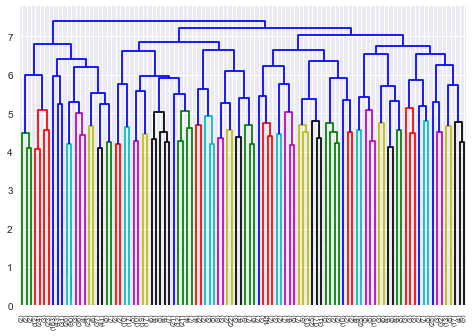

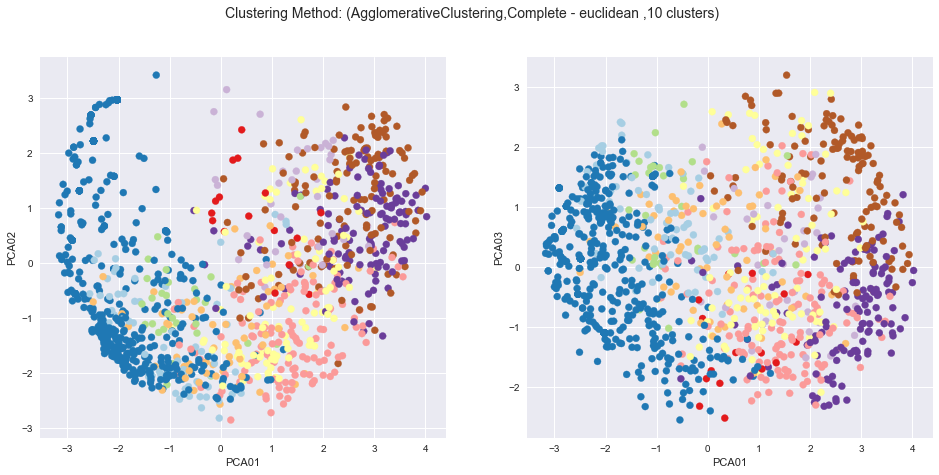

In [228]:
from scipy.cluster import hierarchy

SSE = {}
SILOUHAITE = {}

Z = hierarchy.linkage(X_z, method='complete',metric='euclidean')
dn = hierarchy.dendrogram(Z, truncate_mode='lastp', p=100, leaf_rotation=90., leaf_font_size=7., show_contracted=True)
plt.show()



plt.figure()
labels_h_cc = hierarchy.fcluster(Z, t=10 ,criterion = 'maxclust')
hlp.Clusters_plot(X= X_pca, labels = labels_h_cc,info=["AgglomerativeClustering","Complete - euclidean ","%d clusters"%len(set(labels_h_cc))])


SSE["Agg_complete"] = hlp.getSSE(X_z,X_z[labels_h_cc])

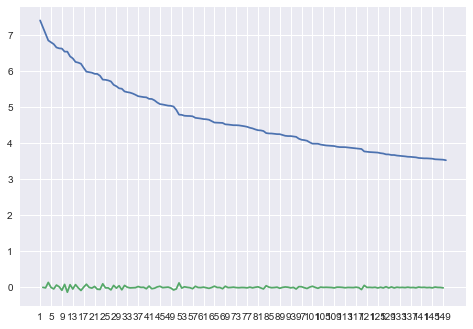

clusters: [  4  11  52  24  18  10  16  14   9  12  50  27   7  31 120 119  32  28
  23  22  84  30  13  95  51   6  83  41  65  40  42  68  69  57 101  58
  45  21  99  37  63 103  96  89 128  43  97  29   8  20  54  53  81  49
  44 130 125 129  91 131 127 109  34  26  25 140  82  15  77 145 146 149
  93   3  79 139 104 100  48  17  35  78  61 110 113  72  88  85  62 136
 117 111 132  98  74  92  86 126  56  33  80 124 118  39  36 142  46 106
 143 135  70  55 137  60  73 122 116   2 107  76  19 123 134  38 112  90
 133 102  94 108  47  87 147   5  67 115  59 114  75 105  64 121 144 148
 141 138  71  66]


In [229]:
last = Z[-150:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.xticks(np.arange(1,len(last),4))
plt.show()
best_ks = np.abs(acceleration_rev).argsort()[::-1]
k =  best_ks+ 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:", k)

### K-Means: Validate different numbers of clusters

In [ ]:
%matplotlib inline
clusters= np.linspace(20,50,20).astype(int)
inertia = []
silouhaite = []
for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster).fit(X_z)
    silouhaite.append(hlp.getSilouhaite(X_z,kmeans.labels_))
    inertia += [np.sqrt(kmeans.inertia_/len(kmeans.labels_))]

plt.figure(figsize=(16,4))
    
plt.subplot(1,2,1)
inertia = np.array(inertia)
plt.title("Total inertia according to clusters")    
plt.plot(np.arange(0,len(clusters)),inertia)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)


acc = np.diff(inertia, 2)  # 2nd derivative of the inertia curve
#plt.plot(np.arange(2,len(clusters)), acc)
best_ks = acc.argsort()[::-1]
k =  best_ks+ 2  # if idx 0 is the max of this we want 2 clusters
print ("clusters:",clusters[k])



plt.subplot(1,2,2)
silouhaite = np.array(silouhaite)
plt.title("Silouhaite score according to clusters")    
plt.plot(np.arange(0,len(clusters)),silouhaite)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)
best_ks = silouhaite.argsort()[::-1]
print("clusters:",clusters[best_ks])


plt.show()


## Ward Clustering

29786.87797154133


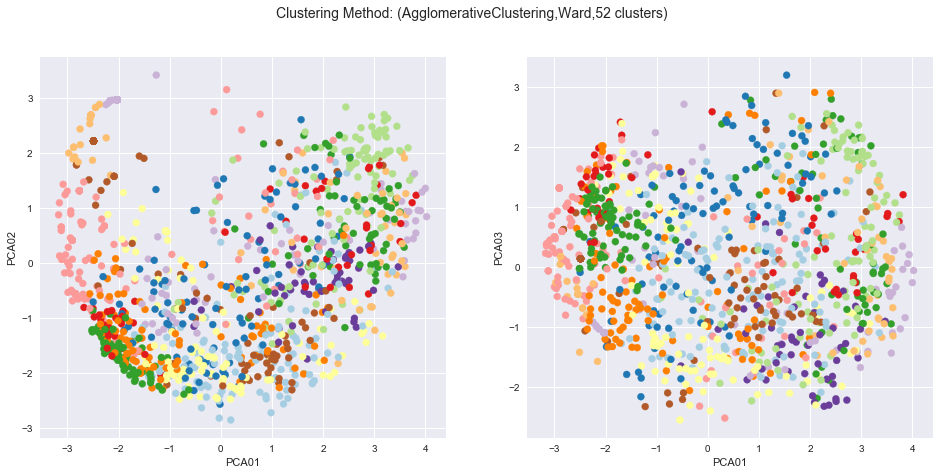

In [230]:
n_cluster = 52

from sklearn.cluster import AgglomerativeClustering

ward = AgglomerativeClustering(n_clusters=n_cluster, linkage='ward').fit(X_z)
label = ward.labels_

SSE['Ward'] = hlp.getSSE(X_z,X_z[label])
print(SSE['Ward'])
hlp.Clusters_plot(X= X_pca, labels = label,info=["AgglomerativeClustering","Ward","%d clusters"%len(set(label))])

## K-means

In [231]:
%matplotlib inline

kmeans = KMeans(n_clusters=n_cluster).fit(X_z)
label = kmeans.labels_
labels_kmeans = label

SSE["kMeans"] = hlp.getSSE(X_z,X_z[labels_kmeans])

### PCA representation of the clustering

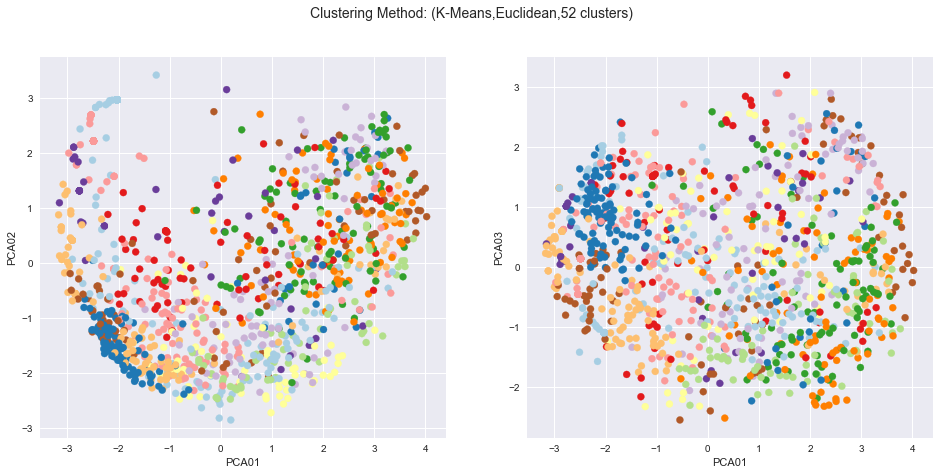

In [232]:
X = X_pca[:,:3]
hlp.Clusters_plot(X= X_pca, labels = label,info=["K-Means","Euclidean","%d clusters"%len(set(label))])

## Custom Distances

In [233]:
from scipy.stats import spearmanr
def spearmanr_dist(x,y):
    rho, pval = spearmanr(x,y)
    return rho


r,p = spearmanr(X_z)
np.fill_diagonal(r,0)

In [234]:
from external import kMedoids
from scipy.spatial.distance import pdist,squareform

n_obs = X_z.shape[1]
corr_distance = squareform(pdist(X_z, 'correlation'))
euclid_distance = squareform(pdist(X_z, 'euclidean'))
sqcorr_distance = corr_distance**2
#spearman_distance = squareform(pdist(X_z, lambda u, v: spearmanr_dist(u,v)))

## K-medoid: validate number of clusters using silouhaite

In [ ]:
%matplotlib inline
clusters= np.linspace(20,50,20).astype(int)
silouhaite = []
inertia = []
for cluster in clusters:
    labels, medoids = kMedoids.cluster(euclid_distance,k= cluster)
    silouhaite.append(hlp.getSilouhaite(X_z,labels))
    sse = hlp.getSSE(X_z,X_z[labels])
    inertia.append(np.sqrt(sse/len(labels_kmedoids)))
    

plt.figure(figsize=(16,4))
    
plt.subplot(1,2,1)
inertia = np.array(inertia)
plt.title("Total inertia according to clusters")    
plt.plot(np.arange(0,len(clusters)),inertia)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)


acc = np.diff(inertia, 2)  # 2nd derivative of the inertia curve
#plt.plot(np.arange(2,len(clusters)), acc)
best_ks = acc.argsort()[::-1]
k =  best_ks+ 2  # if idx 0 is the max of this we want 2 clusters
print("clusters:",clusters[k])



plt.subplot(1,2,2)
silouhaite = np.array(silouhaite)
plt.title("Silouhaite score according to clusters")    
plt.plot(np.arange(0,len(clusters)),silouhaite)#scale it to acc2
plt.xticks(np.arange(0,len(clusters)),clusters)
best_ks = silouhaite.argsort()[::-1]
print("clusters:",clusters[best_ks])

## K-medoids Clustering

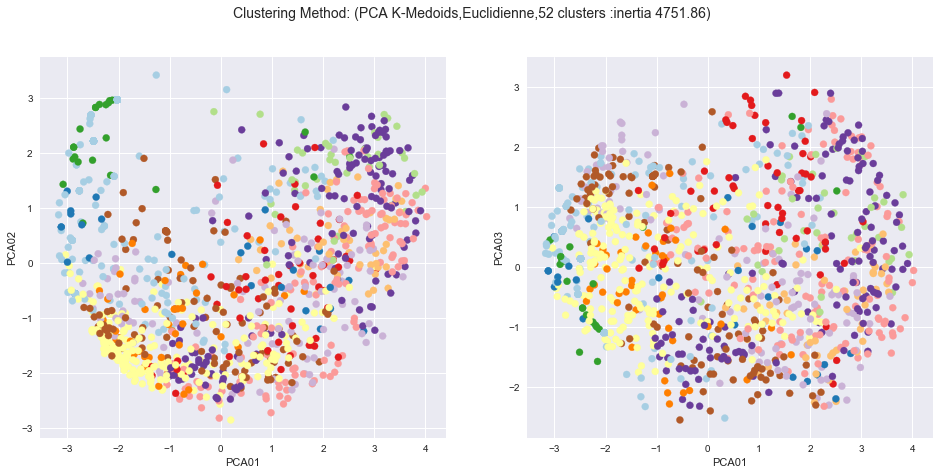

In [244]:
n_cluster = 52
label, medoids_euc = kMedoids.cluster(euclid_distance,k= n_cluster)
labels_kmedoids = label

labels_kmedoids_corr,medoids_corr = kMedoids.cluster(corr_distance,k= n_cluster)
labels_kmedoids_spear,medoids_spear = kMedoids.cluster(corr_distance,k= n_cluster)


SSE["kMedoids"] = hlp.getSSE(X_z,X_z[labels_kmedoids])
SSE["kMedoids_corr"] = hlp.getSSE(X_z,X_z[labels_kmedoids_corr])
SSE["kMedoids_spear"] = hlp.getSSE(X_z,X_z[labels_kmedoids_spear])


SILOUHAITE["kMedoids"] = hlp.getSilouhaite(X_z,labels_kmedoids)
SILOUHAITE["kMedoids_corr"] = hlp.getSilouhaite(X_z,labels_kmedoids_corr)
SILOUHAITE["kMedoids_spear"] = hlp.getSilouhaite(X_z,labels_kmedoids_spear)


hlp.Clusters_plot(X= X_pca, labels = label
                  ,info=["PCA K-Medoids","Euclidienne","%d clusters :inertia %.2f"%(len(set(label)),SSE["kMedoids"])])

### t-SNE representation of the clustering

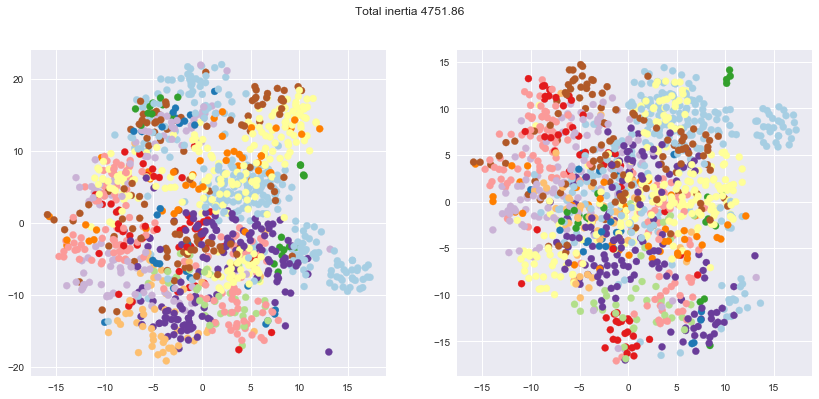

In [249]:
X_tsne = TSNE(n_components = 3).fit_transform(X_z)

plt.figure(figsize=(14,6))
colors = np.array([str(item/255.) for item in labels_kmedoids])
plt.suptitle("Total inertia %.02f"%SSE["kMedoids"])  
plt.subplot(1,2,1)
plt.scatter(X_tsne[:,0],X_tsne[:,1],cmap ="Paired" ,c=colors)
plt.subplot(1,2,2)
plt.scatter(X_tsne[:,0],X_tsne[:,2],cmap ="Paired" ,c=colors)
plt.show(block = True)

## Clustering methods Metrics

In [246]:
for k,v in SSE.items():
    print(" \"%s\" : %.2f"%(k,v))

print()
    
for k,v in SILOUHAITE.items():
    print(" \"%s\" : %.2f"%(k,v))

 "Agg_complete" : 30593.57
 "kMedoids_spear" : 4670.45
 "kMedoids" : 4751.86
 "kMeans" : 28285.76
 "kMedoids_corr" : 4448.95
 "Ward" : 29786.88

 "kMedoids_corr" : 0.22
 "kMedoids" : 0.01
 "kMedoids_spear" : 0.18


# Save Clustering Results

In [250]:
version = 1

file_name = "p2_clustering_clean_week_v%d.csv"%version


def labels_to_df(labels):
    medoid_cluster_dict = dict()
    
    medoids = list(set(labels))
    for i,l in enumerate(medoids):
        medoid_cluster_dict[l] = i+1

    pd_tuples_list = list(product_df_full[row_headers].itertuples(index=False))
    headers_list = [tuple(x) for x in pd_tuples_list]
    
    rows=[]
    for i,h in enumerate(headers_list):
        m = labels[i]
        rows.append([h[0],medoid_cluster_dict[m],"%s"%(headers_list[m],)])


    label_df = pd.DataFrame(rows,columns = row_headers + ["Cluster","Centroid"])
    return label_df




eucl_df = labels_to_df(labels_kmedoids)
corr_df = labels_to_df(labels_kmedoids_corr)
spear_df = labels_to_df(labels_kmedoids_spear)


eucl_df.to_csv(models_path+"euc_"+file_name, sep=';', encoding='utf-8')
corr_df.to_csv(models_path+"corr_"+file_name, sep=';', encoding='utf-8')
spear_df.to_csv(models_path+"spear_"+file_name, sep=';', encoding='utf-8')


print(eucl_df.shape)
eucl_df.head()

(1230, 3)


Product  Cluster            Centroid
0  3250001070000        1  ('3250001070000',)
1  3250001080000        2  ('3250001080000',)
2  3250003060000        3  ('3250003060000',)
3  3250066040000       37  ('3330135005600',)
4  3250067030000        8  ('3258806000000',)

# Display Clustering Results

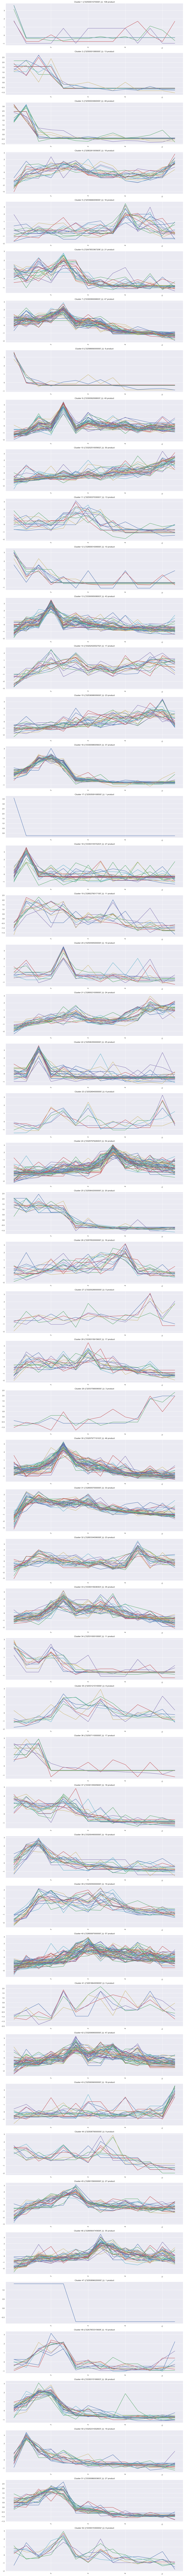

In [248]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = eucl_df,headers = row_headers)
plt.show()

In [ ]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = corr_df,headers = row_headers)

In [ ]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = spear_df,headers = row_headers)

In [ ]:
carr = hlp.Cluster_series_plot(data_df = product_df_full, cluster_df = eucl_df,headers = row_headers,centroid_only = True)

########################################################################################################################

########################################################################################################################

# Other Methods

## BIRCH Algorithm

In [ ]:
label = Birch(n_clusters= n_cluster, threshold=0.5, compute_labels=True).fit_predict(X_z)
labels_birch = label

SSE["Birch"] = hlp.getSSE(X_z,X_z[labels_birch])

hlp.Clusters_plot(X= X_pca, labels = label,info=["PCA BIRCH","(50, 0.5)","%d clusters"%len(set(label))])

## SOM

In [ ]:
from minisom import MiniSom   


som = MiniSom(14, 14, 104, sigma=0.5, learning_rate=0.01) # initialization of 6x6 SOM

som.train_batch(X_z, 1000) # trains the SOM with 100 iterations

# Plotting the response for each pattern in the iris dataset
plt.bone()
plt.pcolor(som.distance_map().T)  # plotting the distance map as background
plt.colorbar()

qnt = som.quantization(X_z)
x,y = som.winner(X_z[0])


plt.show()


# SOM with SOMpy

In [1]:
import sompy
mapsize = [14,14]
som = sompy.SOMFactory().build(Data1, mapsize, mask=None, mapshape='planar', lattice='rect', normalization='var', initialization='pca', neighborhood='gaussian', training='batch', name='sompy')  
# this will use the default parameters, but i can change the initialization and neighborhood methods
som.train(n_job=1, verbose='info')  # verbose='debug' will print more, and verbose=None wont print anything

AttributeError: 'module' object has no attribute 'SOMFactory'

# Fuzzy c-means

In [ ]:
import skfuzzy as fuzz

ncenters = n_cluster
cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        X_z.T, ncenters, 2, error=0.005, maxiter=1000, init=None)



labels_fuzzy = np.argmax(u, axis=0)

## Representation methods
### PAA_SAX representation

In [ ]:
from pyts.transformation import PAA,SAX
from pyts.visualization import plot_paa, plot_sax
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
ts = X_z[0].reshape(1,-1)

paa_win = 100
sax_bin = 30


#PAA example
paa = PAA(window_size=None, output_size=paa_win, overlapping=True)
X_paa = paa.transform(ts)
plot_paa(ts[0], window_size=None, output_size=paa_win, overlapping=True, marker='o')

#SAX example
sax = SAX(n_bins=sax_bin, quantiles='gaussian')
X_sax = sax.transform(X_paa)
plot_sax(X_paa[0], n_bins=sax_bin, quantiles='gaussian')
plt.show()

#Extract SAX vector
X_SAX= []
for x in X_z:
    ts = x.reshape(1,-1)
    paa = PAA(window_size=None, output_size=paa_win, overlapping=True)
    X_paa = paa.transform(ts)
    sax = SAX(n_bins=sax_bin, quantiles='gaussian')
    X_sax = sax.transform(X_paa)[0]
    X_SAX.append(list(X_sax))

#Cast back to int
X_SAX = np.array(X_SAX).astype('|S1')
X_SAX = X_SAX.view(np.uint8) - 98
# X_z = X_SAX
# N,M  = X_z.shape


In [125]:
tuple([1,2,3])

(1, 2, 3)